# <h2 align="center">DLOps - Introdução</h2>

Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Neste script começamos uma nova série onde aprenderemos sobre `DLOps`. O termo se deriva de `DevOps` que faz referência ao conjunto de ferramentas de software que nos ajuda ao desenvolvimento e instanciamento em produção do código, asegurando sua robustez e qualidade durante tudo o ciclo de vida.

Então, falaremos sobre `MLOps` quando nos refiramos às ferramentas que nos ajuda a desenvolver e colocar em produção algoritmos de Machine Learning, o `DLOps` em caso do Deep Learning. 

Estas ferramentas incluirão, entre outras, a automatização no treinamento de modelos, versionado de Datasets, instanciamento em produção automatizada e monitoramento de modelos em produção.

Para mais estudos, recomendo fazer [click aqui](https://github.com/graviraja/MLOps-Basics).




objetivo:

O principal objetivo deste script é começar, desde zero, uma infraestrutura completa de `Deep Learning` com especial foco na automatização para que você possa aplicar isto em seus projetos. 

Para esta tarefa, desenvolveremos um classificador de imagens de dígitos manuscritos usando o Dataset [MNIST](http://yann.lecun.com/exdb/mnist/). 

O outro principal foco é a descentralização, de maneira que esta infraestrutura possa ser implementada em equipos com responsabilidades separadas: enquanto uma equipe de científicos de Dados trabalha nos Datasets (coletando e etiquetando novas amostras) outra equipe de Engenheiros poderá trabalhar nos modelos de maneira separada e remota. Por outro lado, a equipe de QA monitorará os modelos em produção para alertar de qualquer anomalia. 

# Nosso Dataset

In [63]:
# Descarregamos nosso Dataset

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split



X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)



In [64]:
import numpy as np
import pandas as pd


X_df = pd.DataFrame(X)
X_df.head() 

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
X_df.shape

(70000, 784)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

len(X_train), len(X_test), len(y_train), len(y_test)

(60000, 10000, 60000, 10000)

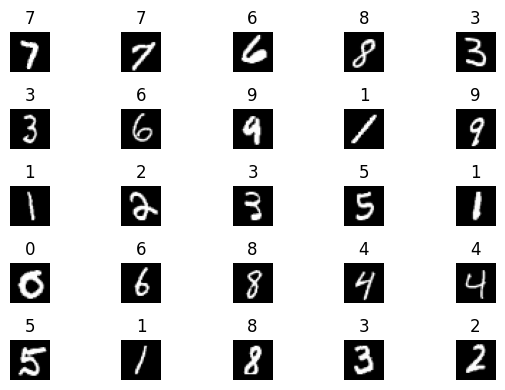

In [67]:
# Graficamos nossos Dados. Cada Dígito com sua Label

import matplotlib.pyplot as plt
import random



fig = plt.figure(dpi=100)
for ix in range(25):
	ax = plt.subplot(5, 5, ix + 1)
	i = random.randint(0, len(X_train)-1)
	img, label = X_train[i], y_train[i]
	ax.imshow(img.reshape(28,28), cmap='gray')
	ax.set_title(label)
	ax.axis('off')
plt.tight_layout()
plt.show()


Em nossa primeira iteração, faremos um classificador binário simples que detecte apenas o número $3$. Mis para frente iremos complicando os requisitos, o qual nos dará opção a gerar diferentes versões de nosso Dataset e assim ver um exemplo das ferramentas necessárias para isso. Ademais, nós ficaremos com uma pequena amostra para começar com um Dataset limitado.

In [68]:
import numpy as np


X_train_3 = X_train[y_train == '3'][:100]
X_train_no_3 = X_train[y_train != '3'][:100]


len(X_train_3), len(X_train_no_3)

(100, 100)

In [69]:
def plot_samples(X):
	fig = plt.figure(dpi=100)
	for ix in range(25):
		ax = plt.subplot(5, 5, ix + 1)
		i = random.randint(0, len(X)-1)
		img = X[i]
		ax.imshow(img.reshape(28,28), cmap='gray')
		ax.axis('off')
	plt.tight_layout()
	plt.show()

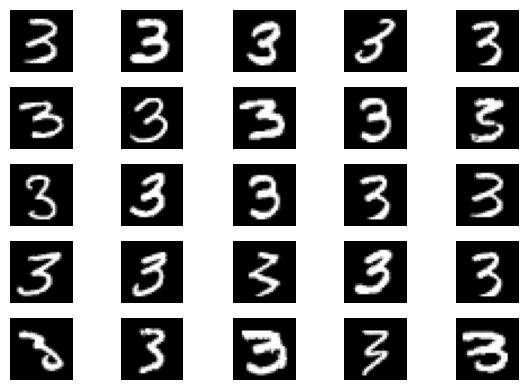

In [70]:
# Visualizamos nossos Dados de Treinamento, apenas para o dígito 3
plot_samples(X_train_3)

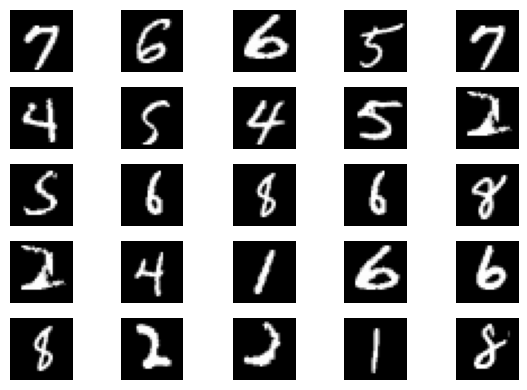

In [71]:
# Não Dígito 3
plot_samples(X_train_no_3)

Agora salvamos as imagens em carpetas diferentes, separando ademais um $20\%$ das amostras para o conjunto de test. 

A medida que nossa aplicação vaja crescendo e sendo usado cada vez mais, deveremos identificar aqueles exemplos onde falha, etiquetá-lo e incluí-lo no conjunto de test. 

Por outro lado, deveremos coletar exemplos similares, etiquetá-los e adicioná-los ao conjunto de treinamento. Desta maneira, ao re-treinar os modelos, nos aseguraremos de ir corriguindo erros de maneira adequada (este processo se conhece como <font color="orange">Active Learning</font> ). 

In [72]:
#!pip install scikit-image

In [83]:
import os 
from pathlib import Path
from skimage.io import imsave
import shutil



path = Path('dataset') # Aqui gero uma carpeta que se chame "dataset"

def generate_dataset(X_train_3, X_train_no_3, test_size): 
	shutil.rmtree(path)
	os.makedirs(path, exist_ok=True)

	splits = ['train', 'test']
	for split in splits:
		os.makedirs(path / split, exist_ok=True)
		os.makedirs(path / split / '3', exist_ok=True)
		os.makedirs(path / split / 'no3', exist_ok=True)
		if split == 'train':
			X1, X2 = X_train_3[:-test_size], X_train_no_3[:-test_size]
		else:
			X1, X2 = X_train_3[-test_size:], X_train_no_3[-test_size:]
		for x1, x2 in zip(X1, X2):
			imsave(path / split / '3' / f'{random.randint(0, 99999):05d}.png', x1.reshape(28,28).astype('uint8'))
			imsave(path / split / 'no3' / f'{random.randint(0, 99999):05d}.png', x2.reshape(28,28).astype('uint8'))

In [84]:
# Dos 100 dados, 20 são para test.
generate_dataset(X_train_3, X_train_no_3, 20) 

In [85]:
from glob import glob

def get_paths():
	train_3 = glob(str(path / 'train' / '3' / '*.png'))
	train_no3 = glob(str(path / 'train' / 'no3' / '*.png'))
	test_3 = glob(str(path / 'test' / '3' / '*.png'))
	test_no3 = glob(str(path / 'test' / 'no3' / '*.png'))
	return train_3, train_no3, test_3, test_no3

train_3, train_no3, test_3, test_no3 = get_paths()

len(train_3), len(train_no3), len(test_3), len(test_no3)

(80, 80, 20, 20)

In [86]:
from skimage.io import imread 

def plot_images(paths):
	fig = plt.figure(dpi=100)
	for ix in range(25):
		ax = plt.subplot(5, 5, ix + 1)
		i = random.randint(0, len(paths)-1)
		img = imread(paths[i])
		ax.imshow(img, cmap='gray')
		ax.axis('off')
	plt.tight_layout()
	plt.show()

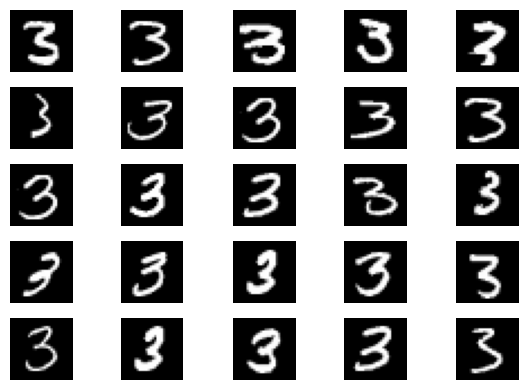

In [87]:
plot_images(train_3)

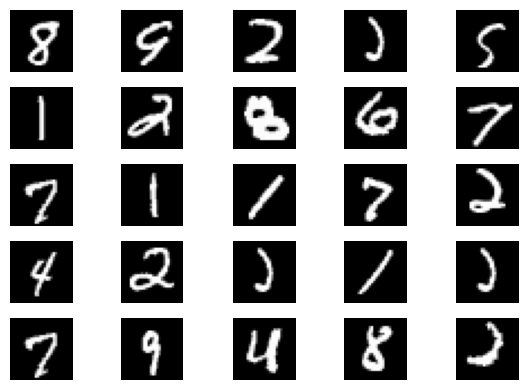

In [88]:
plot_images(train_no3)

# Versionamento de Dados

Neste primeiro ponto temos uma primeira versão de nosso Dataset que usaremos para treinar nosso primeiro modelo. Sabemos que no futuro o Dataset irá evoluindo, adicionando mais exemplos e classes (e em função da aplicação potencialmente novas tarefas). 

A opção mais simples de gerenciar isto seria gerar um **.zip** com nossos Dados, colocar um nome (<font color="orange">por exemplo:</font> mnist-V1.0) e salvar esse arquivo em algum servidor o qual possa acceder os engenheiros de Deep Learning para treinar modelos. 

O mesmo poderíamos fazer no software 1.0 com nosso código (<font color="orange">e durante muito tempo assim foi feito, talvez haja empresas que ainda façam isso 😂</font>), não entanto faz um tempinho que existe o uso de ferramentas de <font color="orange">controle de versão</font> são muito mais úteis e eficazes. 

O exemplo principal é `git`. Assim para gerenciar nossos Dados (e mais para frente modelos, métricas e incluso `pipelines` de treinamento) usaremos uma ferramenta de `controle de versão` específica para trabalhar com grandes Dados em entornos de *Machine Learning* conhecida como [dvc](https://dvc.org/). `dvc` trabalha em conjunto com `git`, assim que o primeiro que precisaremos será um repositorio de `git`, que podes armazenar em `Github`, para gerenciar o projecto.

> Em meu caso crie este [repo](https://github.com/EddyGiusepe/DLOps_MLOps_para_Deep_Learning) que usarei durante toda esta implementação.


Você pode instalar (via Terminal) [dvc](https://dvc.org/), assim:

```
pip install dvc
```
Logo você pode inicializar seu repositório, assim:

```
dvc init
```
Devemos executar o comando ao mesmo nível que `git`, já que `dvc` utiliza git para o controle de versão dos metadados associados aos Dados (arquivos grandes). Isto gerará uma carpeta `.dvc` e um arquivo `.dvcignore` similar ao git. Agora podemos adicionar a carpeta com os Dados ao repositório com o comando:

```
dvc add dataset
```
O seguinte passo será conectar `dvc` com um serviço de armazenamento remoto onde salvaremos nosso Dados. Você pode utilizar diferentes serviços, [aqui](https://dvc.org/features) tem uma lista. Neste caso usaremos [firebase](https://firebase.google.com/), já que mais para frente usaremos outras características como a base de Dados.

<font color="yellow">dvc remote add -d eddyStorage gs://eddy_copy_link_do_firebase</font>

Para que `dvc` possa aceder ao `bucket` precisaremos configurar a variável de entorno `GOOGLE_APPLICATION_CREDENTIALS`, seguindo a [documentação](https://cloud.google.com/docs/authentication/client-libraries#python) ou descarregando  as credenciais desde a consola do `firebase`. 


<font color="yellow">export GOOGLE_APPLICATION_CREDENTIALS=google_application_credentials.json</font>


Uma vez conectado, poderemos **sincronizar** nosso Dataset com o comando a seguir:
```
dvc push
```
Agora podemos testar, eliminando a pasta `dataset` e para recuperá-la podes escrever a seguinte linha de comando:

```
dvc pull dataset.dvc
```
Usaremos `git` para criar uma nova versão com o comando:

```
git tag -a v0 -m "version 0"
```
`git` salvará os arquivos específicos de `dvc` do commit com a tag determinada.
```
git add .
git commit -m "primera versión"
git push
git push origin --tags
```
Neste ponto, qualquer profissional com acesso ao repositório de `git` e `dvc` (<font color="orange">com as credenciais necessárias de `firebase`</font>) poderá ter acesso ao dataset e a todas suas versões de maneira simples e remota para utilizá-lo no treinamento de modelos ou modificá-los ou criar novas versões. 
```
dvc pull
```









# Criando novas versões

Agora vamos gerar uma nova versão do Dataset com $100$ amostras mais das que tínhamos anteriormente.

In [90]:
X_train_3 = X_train[y_train == '3'][:200]
X_train_no_3 = X_train[y_train != '3'][:200]

len(X_train_3), len(X_train_no_3)

(200, 200)

In [61]:
generate_dataset(X_train_3, X_train_no_3, 40)

In [89]:
train_3, train_no3, test_3, test_no3 = get_paths()

len(train_3), len(train_no3), len(test_3), len(test_no3)

(80, 80, 20, 20)

Usaremos os comandos vistos anteriormente para criar uma nova versão:

```
dvc add dataset
dvc push
git tag -a v1 -m "version 1" 
git add .
git commit -m 'nueva version'
git push
git push origin --tags
```

Agora que temos diferentes versões podemos ir trocando entre essas versões segundo a nossa necessidade:

```
git checkout tags/v0
dvc pull
```

In [40]:
# versión 0 con 80/20 split

train_3, train_no3, test_3, test_no3 = get_paths()

len(train_3), len(train_no3), len(test_3), len(test_no3)

(160, 160, 40, 40)

```
git checkout tags/v1
dvc pull
```

In [82]:
# versión 1 con 160/40 split

train_3, train_no3, test_3, test_no3 = get_paths()

len(train_3), len(train_no3), len(test_3), len(test_no3)

(77, 80, 20, 20)

<font color="pink">RESUMO:</font>

Neste script aprendimos a usar a ferramenta de controle de versões [dvc](https://dvc.org/), a qual usamos para versionar nosso Dataset, mas também usaremos mais para frente para versionar modelos, métricas e incluso `pipelines` completas de treinamento muito úteis para automatização. 

Então, aqui vimos especificamente como gerar várias versões de um Dataset para `classificação binária` de dígitos manuscritos que usaremos de aqui para frente a medida que vajamos introduzindo técnicas e ferramentas de `DLOps` e o qual iremos modificando (e versionando), adicionando mais exemplos e mais classes.